In [1]:
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/iPyNb/NERSC_Import') #or point to your iPyNb/NERSC_Import folder. It should be in your home directory for easy setup
from pyROOT_import import *
from mpl_numpy_scipy_import import *
from aLib_import import *
%pylab inline  
#always do this for plotting...  don't ask why
#now set the size of figures to display in window
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> load in Run03 WS data </h1>

In [3]:
chain = TChain('golden')
#chain.Add('/project/projectdirs/lux/users/acurrie/Run3_DP2.0/*.root')
chain.Add('/project/projectdirs/lux/data/golden/root/Golden_Run03/Golden_1503*.root')

#chain2 = TChain('golden')
chain.Add('/project/projectdirs/lux/data/golden/root/CH3T_Run03/Golden_CH3T_Dec.root')

chain.Add('/project/projectdirs/lux/data/golden/root/DD_Run03/Golden_DD*.root')

2

<h1> Check for S1 stability in Run03 based on Kr peaks in the WS data </h1>

In [8]:
c3 = rootnotes.default_canvas(name='WS_S1', size=(1000, 800))

In [9]:
fid_vol=TCut('drift>35 && drift<308 && correctedRadius<20')
area_cut=TCut('s2area_raw>150 && s1area>150 && s1area<350 && s2area<20000 && s2area>2000')
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')

In [10]:
#density_plt_hst=TH2F('S1_Kr_WS','S1_Kr_WS;luxstamp;S1_{c}',500,7250,8450,100,150,350)
#combined_cut=TCut(fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle())
#n=chain.Draw('s1area:(luxstamp/10**12)>>S1_Kr_WS',combined_cut,'colz')
n=chain.Draw('s1area:(luxstamp/10**12)',fid_vol+area_cut+bad_area_cut)

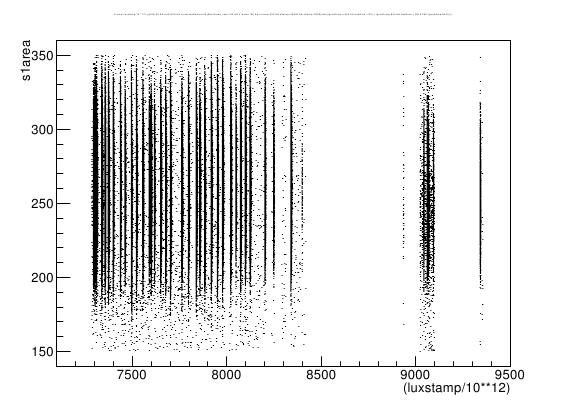

In [13]:
#c3.SetLogz(0)
#gStyle.SetOptStat(0)
#gStyle.SetPalette(55)
#gStyle.SetNumberContours(100)
c3.SaveAs('Run03_Stability_plots/S1c_scatter.pdf')
c3

In [14]:
s1c = ndarray( (n,),dtype= float64, buffer=(chain.GetV1()))
luxstamp = ndarray( (n,),dtype= float64, buffer=(chain.GetV2()))

In [15]:
cut=luxstamp > 1000;
s1c=s1c[cut]
luxstamp=luxstamp[cut]

In [16]:
H, xedges, yedges = histogram2d(luxstamp, s1c, bins=400, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

In [17]:
#HH, xedges = histogram(luxstamp, bins=200, range=None, normed=False)
#x_bin_center=(xedges[:-1]+xedges[1:])/2

left_edge=xedges[:-1]
right_edge=xedges[1:]

s1_means=zeros_like(x_bin_center)
s1_means_sig=zeros_like(x_bin_center)

for ii in range(0,x_bin_center.size):
    range_cut=(luxstamp>left_edge[ii]) & (luxstamp<right_edge[ii])
    s1_means[ii]=mean(s1c[range_cut])
    s1_means_sig[ii]= std(s1c[range_cut])/sqrt(s1c[range_cut].size)
    if s1c[range_cut].size <1000: # at least 1000 points for the fit
        s1_means[ii]=0


/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:95: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in double_scalars


In [19]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=x_bin_center*10**4/3600/24
luxdatenum=luxstamp2day+lux_epoch

In [20]:
sig_s1_mean=std(s1_means[s1_means>0]/mean(s1_means[s1_means>0]))
normWS_mean=mean(s1_means[s1_means>0][luxdatenum[s1_means>0]<datestr2num('Sep 1st 2013 at 00:00')])

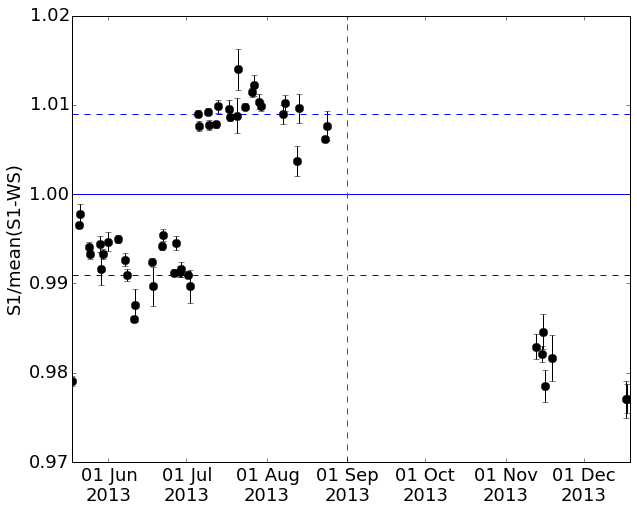

In [22]:
plt.plot_date(luxdatenum[s1_means>0],s1_means[s1_means>0]/normWS_mean,'.k')
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1,1],'-b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1.009,1.009],'--b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[.991,.991],'--b')
plt.errorbar(luxdatenum[s1_means>0],s1_means[s1_means>0]/normWS_mean,
             s1_means_sig[s1_means>0]/normWS_mean,fmt=".k",markersize=16)
plt.rcParams.update({'font.size': 18}) #increase all fontsizes
plt.plot_date([datestr2num('Sep 1st 2013 at 00:00'),datestr2num('Sep 1st 2013 at 00:00')],[0.97,1.02],'--m')
#plt.xticks(fontsize=16)
plt.ylabel('S1/mean(S1-WS)')
#plt.xlabel('Date')

plt.savefig('Run03_Stability_plots/S1c_stability.png')

In [151]:
aa=s1_means[s1_means>0]/normWS_mean
mean(aa[-2:])

0.97706123333255435

<h1> Check for S2 stability in WS from Kr peaks </h1>

In [23]:
c4 = rootnotes.default_canvas(name='WS_S2', size=(1000, 800))

In [24]:
fid_vol=TCut('drift>35 && drift<308 && correctedRadius<20')
area_cut=TCut('s2area_raw>150 && s1area>150 && s1area<350 && s2area<20000 && s2area>2000')
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')
n=chain.Draw('s2area/100:(luxstamp/10**12)',fid_vol+area_cut+bad_area_cut)

In [25]:
n

1497660L

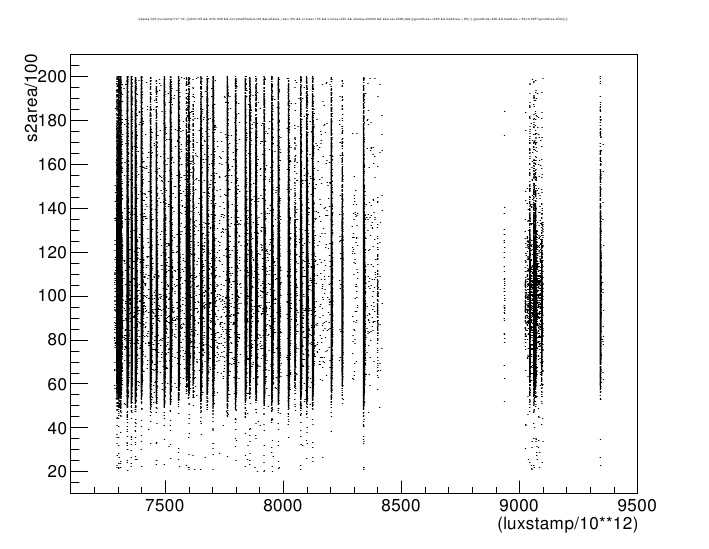

In [26]:
c4.SaveAs('Run03_Stability_plots/S2c_scatter.pdf')
c4

In [27]:
s2c = ndarray( (n,),dtype= float64, buffer=(chain.GetV1()))
luxstamp = ndarray( (n,),dtype= float64, buffer=(chain.GetV2()))


In [28]:
cut=(luxstamp > 7200) & (luxstamp < 9500) ;
s2c=s2c[cut]
luxstamp=luxstamp[cut]

In [29]:
H, xedges, yedges = histogram2d(luxstamp, s2c, bins=400, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

left_edge=xedges[:-1]
right_edge=xedges[1:]

s2_means=zeros_like(x_bin_center)
s2_means_sig=zeros_like(x_bin_center)

for ii in range(0,x_bin_center.size):
    range_cut=(luxstamp>left_edge[ii]) & (luxstamp<right_edge[ii])
    s2_means[ii]=mean(s2c[range_cut])
    s2_means_sig[ii]= std(s2c[range_cut])/sqrt(s2c[range_cut].size)
    if s2c[range_cut].size <1000: # at least 1000 points for the fit
        s2_means[ii]=0



In [30]:
#plt.contourf(x_bin_center,y_bin_center,H,20)

In [31]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=x_bin_center*10**4/3600/24
luxdatenum=luxstamp2day+lux_epoch

normWS_S2mean=mean(s2_means[s2_means>0][luxdatenum[s2_means>0]<datestr2num('Sep 1st 2013 at 00:00')])

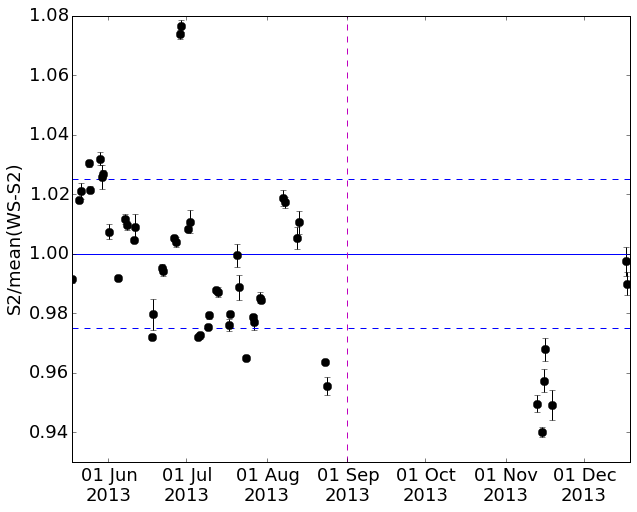

In [32]:
plt.plot_date(luxdatenum[s2_means>0],s2_means[s2_means>0]/normWS_S2mean,'.k')
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1,1],'-b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[1.025,1.025],'--b')
plt.plot_date([luxdatenum.min(),luxdatenum.max()],[.975,.975],'--b')
plt.errorbar(luxdatenum[s2_means>0],s2_means[s2_means>0]/normWS_S2mean,
             s2_means_sig[s2_means>0]/normWS_S2mean,fmt=".k",markersize=16)
plt.rcParams.update({'font.size': 18}) #increase all fontsizes
plt.plot_date([datestr2num('Sep 1st 2013 at 00:00'),datestr2num('Sep 1st 2013 at 00:00')],[0.93,1.08],'--m')
plt.ylim([0.93,1.08])
plt.ylabel('S2/mean(WS-S2)')
#plt.xlabel('Date')

plt.savefig('Run03_Stability_plots/S2c_stability.png')

In [97]:
sig_s2_mean=std(s2_means[s2_means>0]/mean(s2_means[s2_means>0]))

In [145]:
aa=s2_means[s2_means>0]/normWS_S2mean

In [147]:
mean(aa[-7:-3])

0.95373285616199288

In [149]:
mean(aa[-2:])

0.99365061158134549